# Sistema de Recomendação 

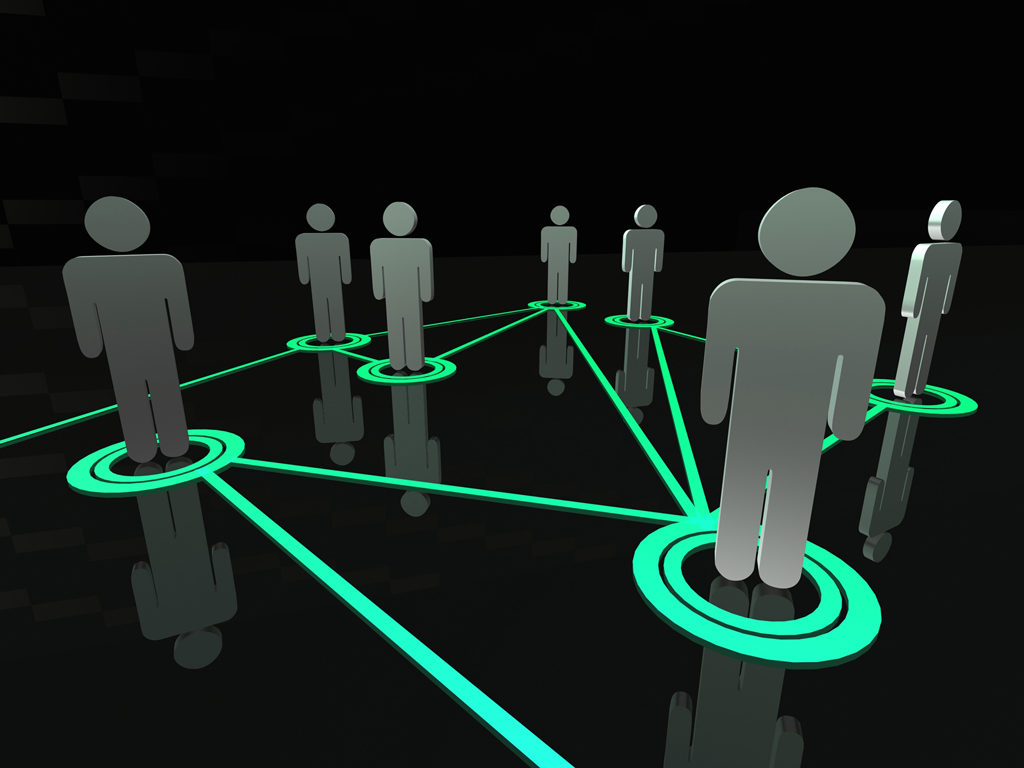

In [1]:
from IPython.display import Image
Image('photo.jpg')

### Detalhes do produto

O objetivo deste produto é fornecer um serviço automatizado que recomenda leads para um usuário dado sua atual lista de clientes (Portfólio).

Algumas empresas gostariam de saber quem são as demais empresas em um determinado mercado (população) que tem maior probabilidade se tornarem seus próximos clientes. Ou seja, a sua solução deve encontrar no mercado quem são os leads mais aderentes dado as características dos clientes presentes no portfólio do usuário.

Além disso, sua solução deve ser agnóstica ao usuário. Qualquer usuário com uma lista de clientes que queira explorar esse mercado pode extrair valor do serviço.

Para o desafio, deverão ser consideradas as seguintes bases:

**Mercado**: Base com informações sobre as empresas do Mercado a ser considerado. 

**Portfolio 1**: Ids dos clientes da empresa 1 

**Portfolio 2**: Ids dos clientes da empresa 2 

**Portfolio 3**: Ids dos clientes da empresa 3

Obs: todas as empresas(ids) dos portfolios estão contidos no Mercado(base de população).

# Análise Exploratória

##### Importação das bibliotecas:

In [2]:
# Manipulação de dados.
import pandas as pd
import numpy as np

# Visualização.
import matplotlib.pyplot as plt
import seaborn as sns

# Processamento de dados.
#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from statistics import mode
from sklearn.preprocessing import MinMaxScaler

# Machine Learning.
from sklearn.cluster import KMeans

# Ignorar mensagens de aviso.
import warnings 
warnings.filterwarnings("ignore")

### Leitura dos arquivos

##### Dados do Mercado

In [3]:
mercado = pd.read_csv('estaticos_market.csv', sep="," , encoding="UTF8")

In [5]:
print("A base de dados Mercado possui {} clientes e {} atributos".format(mercado.shape[0], mercado.shape[1]))

A base de dados Mercado possui 462298 clientes e 182 atributos


In [4]:
# Visualização das primeiras linhas:
mercado.head(2)

,Unnamed: 0,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
0,0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,10 a 15,...,43.738462,93.266667,19.166667,26.0,26.0,27.0,0.0,-3.703704,0.0,0
1,1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,SERVICOS DE ALOJAMENTO/ALIMENTACAO,SERVIÇO,1.463014,1 a 5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


##### Dados dos Portfólios

In [7]:
portfolio_1 = pd.read_csv('estaticos_portfolio1.csv', sep="," , encoding="UTF8")
portfolio_2 = pd.read_csv('estaticos_portfolio2.csv', sep="," , encoding="UTF8")
portfolio_3 = pd.read_csv('estaticos_portfolio3.csv', sep="," , encoding="UTF8")

In [8]:
print("A base de dados do Portfolio 1 possui {} clientes e {} atributos".format(portfolio_1.shape[0], portfolio_1.shape[1]))
print("A base de dados do Portfolio 2 possui {} clientes e {} atributos".format(portfolio_2.shape[0], portfolio_2.shape[1]))
print("A base de dados do Portfolio 3 possui {} clientes e {} atributos".format(portfolio_3.shape[0], portfolio_3.shape[1]))

A base de dados do Portfolio 1 possui 555 clientes e 182 atributos
A base de dados do Portfolio 2 possui 566 clientes e 2 atributos
A base de dados do Portfolio 3 possui 265 clientes e 2 atributos


In [9]:
# Visualização das primeiras linhas:
portfolio_1.head(2)

,Unnamed: 0,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
0,0,dabe79bec87c88ae04e869bf6bd321ee5e1893cecf6625...,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,COMERCIO VAREJISTA,COMERCIO,0.646575,<= 1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,32e5f4e10932153a7ba869cb0386e7e02d49d2461046b8...,False,EMPRESARIO INDIVIDUAL,MA,OUTROS,COMERCIO VAREJISTA,COMERCIO,6.586301,5 a 10,...,NaN,NaN,NaN,0.0,0.0,2.0,NaN,-100.0,0.0,4


In [10]:
# Visualização das primeiras linhas:
portfolio_2.head(2)

,Unnamed: 0,id
0,0,09e95c1a84049001d086470a8f320a19b076f955a89122...
1,1,dc9d155f5bcd3172031e2ec9431786e8871ff4b0ff4728...


In [11]:
# Visualização das primeiras linhas:
portfolio_3.head(2)

,Unnamed: 0,id
0,0,bb61c09449a1c1f8b78955d8b7a7f73599e78358993fe2...
1,1,16843c9ffb920170477118933798510d8d5f00f5c56c12...


Os clientes dos portfolios estão também na base Mercado, essa separação em portfolios nos ajuda a identificar os clientes de cada empresa dentre todos os clientes do mercado. Com isso, ao final da criação do modelo, podemos 
avaliar a sua perfomance verificando quais clientes o modelo categorizou de forma correta. 

Sendo assim, a informação importante dos portfólios é a identificação do cliente representada pela coluna "id".

### Análise dos dados ausentes

In [12]:
# Dataframe que mostra os dados ausentes para cada variável em porcentagem:
df_missing = pd.DataFrame({'Missing_values (%)': (mercado.isna().sum()/mercado.shape[0])*100})

In [13]:
# Variáveis com dados ausentes.
print("Quantidade de colunas com dados faltantes {}%".format(round(df_missing[df_missing['Missing_values (%)']>0].shape[0]/df_missing.shape[0]*100,2)))

Quantidade de colunas com dados faltantes 89.56%


Vemos que quase 90% das colunas possuem ao menos 1 dado ausente.

In [14]:
# Variáveis com mais de 50% de dados ausentes.
print("Quantidade de colunas com 50% de dados faltantes {}%".format(round(df_missing[df_missing['Missing_values (%)']>50].shape[0]/df_missing.shape[0]*100,2)))

Quantidade de colunas com 50% de dados faltantes 71.98%


In [15]:
# Colunas com todos os dados faltantes
df_missing[df_missing['Missing_values (%)']==100]

,Missing_values (%)
qt_alteracao_socio_total,100.0
qt_alteracao_socio_90d,100.0
qt_alteracao_socio_180d,100.0
qt_alteracao_socio_365d,100.0
grau_instrucao_macro_desconhecido,100.0


Aqui, percebe-se que a quantidade de atributos com dados ausentes é bastante significativa - quase 72% dos atributos não possuem ao menos 50% dos seus dados registrados e 5 atributos não possuem nenhum registro. 

##### Estudo das features

In [16]:
list(mercado.columns)

['Unnamed: 0',
 'id',
 'fl_matriz',
 'de_natureza_juridica',
 'sg_uf',
 'natureza_juridica_macro',
 'de_ramo',
 'setor',
 'idade_empresa_anos',
 'idade_emp_cat',
 'fl_me',
 'fl_sa',
 'fl_epp',
 'fl_mei',
 'fl_ltda',
 'dt_situacao',
 'fl_st_especial',
 'fl_email',
 'fl_telefone',
 'fl_rm',
 'nm_divisao',
 'nm_segmento',
 'fl_spa',
 'fl_antt',
 'fl_veiculo',
 'vl_total_tancagem',
 'vl_total_veiculos_antt',
 'vl_total_veiculos_leves',
 'vl_total_veiculos_pesados',
 'fl_optante_simples',
 'qt_art',
 'vl_total_veiculos_pesados_grupo',
 'vl_total_veiculos_leves_grupo',
 'vl_total_tancagem_grupo',
 'vl_total_veiculos_antt_grupo',
 'vl_potenc_cons_oleo_gas',
 'fl_optante_simei',
 'sg_uf_matriz',
 'de_saude_tributaria',
 'de_saude_rescencia',
 'nu_meses_rescencia',
 'de_nivel_atividade',
 'de_indicador_telefone',
 'fl_simples_irregular',
 'vl_frota',
 'empsetorcensitariofaixarendapopulacao',
 'nm_meso_regiao',
 'nm_micro_regiao',
 'fl_passivel_iss',
 'qt_socios',
 'qt_socios_pf',
 'qt_socios_pj

##### Significado de cada feature:

**fl_matriz**: boolean value, true if the CNPJ corresponds to the "matriz".

**de_natureza_juridica**: character, juridic nature of the company.

**sg_uf**: character, initials of the name of the state of the company.

**natureza_juridica_macro**: a macro legal category for "natureza jurídica".

**de_ramo**: description of a macro activity category/branch based on the CNAE code.

**setor**:character, economic sector of the company (Industry, Services, Agrobusiness, Etc.)

**idade_empresa_anos**: numeric value, age of the company.

**idade_emp_cat**: character, age of the company by ranges.

**fl_me**: boolean value, true if the company has the term 'ME' in the end of its legal name.

**fl_sa**: boolean value, true if the company has the term 'SA' in the end of its legal name.

**fl_epp**: boolean value, true if the company has the term 'EPP' in the end of its legal name.

**fl_mei**: boolean value, true if the company has the term 'MEI' in the end of its legal name.

**fl_ltda**: boolean value, true if the company has the term 'LTDA' in the end of its legal name.

**dt_situacao**: date when the "de_situacao" was registered by the IRS.

**fl_st_especial**: boolean value, true if dt_situacao_especial is not null. If it is not null means that some extraordinary situation is identified by the IRS (ESPOLIO DE EMPRESARIO EMPRESA INDIVIDUAL OU EIRELI, FALIDO, EM LIQUIDACAO, LIQUIDACAO JUDICIAL, LIQUIDACAO EXTRA JUDICIAL, REGISTRO NA JUNTA COMERCIAL EM ANDAMENTO, EM LIQUID EXTRA JUDICIAL, RECUPERACAO JUDICIAL, INTERVENCAO)

**fl_email**: boolean value, true if the cnpj has an email registered at the IRF database.

**fl_telefone**: boolean value, true if the company has a phone number registered in IRS database.

**fl_rm**: character, true if the company address is located in an metropolitan area.

**nm_divisao**: character, name description of the primary economic activity of the company 

**nm_segmento**: character, name description of the primary economic activity cluster of the company 

**fl_spa**: boolean, true if the company has it's own fuel station

**fl_antt**:boolean, true if the company is certified by ANTT for trasnportation purposes

**fl_veiculo** :boolean, true if the company owns at least one vehicle

**fl_optante_simples**: boolean, true if the company is taxed according to SIMPLES regime

**vl_total_veiculos_pesados_grupo**: numeric, economic value of the heavy weight vehicles of the economic group of the company

**vl_total_veiculos_leves_grupo**: numeric, economic value of the light weight vehicles of the economic group of the company

**fl_optante_simei**: boolean, true if the company is taxed as an MEI - Individual Micro Entrepreneur (Micro Empreendedor Individual)

**sg_uf_matriz**:character, state of the main office location

**de_saude_tributaria**:character, indicator of health tax status, Green if all tax are OK, Red if none are OK 

**de_saude_rescencia**:character, indicates time of update of the most lagged input of the indicator. 

**nu_meses_rescencia**:character, number of months since the last update of the most lagged input from saude_tributaria

**de_nivel_atividade**:character, probability of being operating, ALTA high probality, BAIXA, low probality. 

**fl_simples_irregular**: boolean, true if the company is taxed under the SIMPLES regime and has a impeditive CNAE (economic activities that are not allowed to be taxed according to the simples regime) revenue above the limit of the regime.
 
**empsetorcensitariofaixarendapopulacao**: numeric, average income from a sample of residents in a census unity (smallest territory area according to IBGE)

**nm_meso_regiao**:character, name of the meso region where the company is located. 

**nm_micro_regiao**:character, name of the micro region where the company is located. 

**fl_passivel_iss**:boolean, true if the company performs any activity that is taxable under ISS - Tax under services.

**qt_socios**: integer value, quantity of partners/shareholders of the cnpj

**qt_socios_pf**: integer value, quantity of partners/shareholders of the cnpj that are persons

**qt_socios_pj**: integer value, quantity of partners/shareholders of the cnpj that are companies 

**idade_media_socios**: numeric value, average age of the partners of the cnpj(considers only the cpf partners)

**idade_maxima_socios**: same as above but with max metric

**idade_minima_socios**: same as above but wiht min metric
 
**qt_socios_st_regular**: integer value, quantity of partners with regular situation under IRS - Receita Federal.

**de_faixa_faturamento_estimado**: character value, class of the estimated revenue of the company. 

**de_faixa_faturamento_estimado_grupo**: character value, class of the sum of estimated revenue for the matrix company and branches.

**vl_faturamento_estimado_aux**: numeric value, value of the estimated revenue. 

**vl_faturamento_estimado_grupo_aux**: numeric value, sum of the estimated revenue for the matrix company and the branches.

**qt_filiais**: self-explanatory.

In [16]:
mercado.head(2)

,Unnamed: 0,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
0,0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,10 a 15,...,43.738462,93.266667,19.166667,26.0,26.0,27.0,0.0,-3.703704,0.0,0
1,1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,SERVICOS DE ALOJAMENTO/ALIMENTACAO,SERVIÇO,1.463014,1 a 5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [17]:
print("Registros marcados como OUTROS em natureza_juridica_macro: {}%".format(round(mercado[mercado['natureza_juridica_macro']=="OUTROS"].shape[0]/mercado.shape[0]*100,2)))

Registros marcados como OUTROS em natureza_juridica_macro: 69.27%


Aqui vejo que a maioria dos registros da coluna "natureza_juridica_macro" está marcada como "OUTROS" o que não me parece uma informação relevante. Além disso, a variável "de_natureza_juridica" descreve essa mesma informação de forma diferente. Logo, decido por eliminar a variável "natureza_juridica_macro". 

Após a análise das variáveis de acordo com seu significado, eu julgo irrelevantes as variáveis:

In [19]:
irrelevantes = ['Unnamed: 0', 'fl_matriz', "natureza_juridica_macro", 'idade_emp_cat', 'fl_me', 'fl_sa', 'fl_epp',
                'fl_mei', 'fl_ltda', 'dt_situacao', 'fl_st_especial', 'fl_email', 'fl_telefone', 'fl_rm', 'fl_spa',
                'fl_antt', 'fl_veiculo', 'vl_total_veiculos_pesados_grupo', 'vl_total_veiculos_leves_grupo',
                'sg_uf_matriz', 'de_saude_rescencia', 'nu_meses_rescencia', 'fl_simples_irregular',
                'empsetorcensitariofaixarendapopulacao', 'nm_micro_regiao', 'fl_passivel_iss', 'qt_socios',
                'qt_socios_pj','qt_socios_pf',  'idade_media_socios', 'idade_maxima_socios', 'idade_minima_socios',
                "qt_socios_st_regular", 'de_faixa_faturamento_estimado_grupo', 'vl_faturamento_estimado_aux',
                'vl_faturamento_estimado_grupo_aux', 'qt_filiais']               

# Pré-processamento dos dados

##### Transformação1: remoção de atributos julgados irrelevantes

In [21]:
mercado_1 = mercado.copy()

In [22]:
# Remoção das variáveis julgadas irrelevantes com base no estudo das features.
mercado_1.drop(columns= irrelevantes, inplace=True)
print("Atualizando: \nNúmero de variáveis: {}".format(mercado_1.shape[1]))

Atualizando: 
Número de variáveis: 145


##### Transformação2: remoção das variáveis com mais de 50% de dados ausentes

In [23]:
mercado_2 = mercado_1.copy()

In [28]:
# Novo dataframe que mostra a quantidade de dados faltantes para cada variável.
df_missing = pd.DataFrame({'Missing_values (%)': (mercado_2.isna().sum()/mercado_2.shape[0])*100})

In [29]:
# Variáveis com mais de 50% de dados faltantes:
var = df_missing[df_missing['Missing_values (%)']>50].index.to_list()

# Remoção das variáveis:
mercado_2.drop(columns = var, inplace=True)

print("Atualizando: \nNúmero de variáveis: {}".format(mercado_2.shape[1]))

Atualizando: 
Número de variáveis: 14


##### Transformação3: remoção dos registros nas variáveis com menos de 5% de dados ausentes

In [30]:
mercado_3 = mercado_2.copy()

In [31]:
# Novo dataframe que mostra a quantidade de dados faltantes para cada variável.
df_missing = pd.DataFrame({'Missing_values (%)': (mercado_3.isna().sum()/mercado_3.shape[0])*100})

In [33]:
# Dataframe com as variáveis com algum dado fatante:
df_missing_var = pd.DataFrame(df_missing[df_missing['Missing_values (%)']>0])

Os dados que possuem menos de 5% dos dados ausentes, decido por eliminar os registros que estão faltando nessas variáveis. 

In [34]:
# Lista com as variáveis com menos de 5% de dados faltantes.
var_less_5 = pd.DataFrame(df_missing_var[df_missing_var['Missing_values (%)']<5]).index.to_list()

Agora verificarei se o cumulativo dos dados ausentes nessas variáveis não passa de 5% dos registros em todo o dataframe.

In [35]:
# Coletando a posição/índice dos dados ausentes:
lista_index = []
for i in var_less_5:
    index = list(mercado_3.loc[(mercado_3[i].isnull()==True)].index)
    lista_index.append(index)

In [36]:
# Concatenando todos os índices e verificando os valores únicos:
indices = []
i=0
while i < len(lista_index):
    indices = indices+lista_index[i]
    i=i+1

indices_unicos = list(set(indices))

# Proporção do total dos valores ausentes das variáveis com menos de 5% de dados faltantes:
print("Total de dados ausentes nas variáveis selecionadas {}%".format(round(len(indices_unicos)/mercado_3.shape[0]*100,2)))

Total de dados ausentes nas variáveis selecionadas 3.21%


Como o total dos valores ausentes nessas variáveis não passa de 5% dos registros, eliminarei esses registros.

In [37]:
# Ordenando os índices:
indices_unicos.sort()

In [38]:
# Dataframe com os índices a serem removidos:
df_remove = mercado_3.iloc[indices_unicos]

In [39]:
# Remoção dos registros:
mercado_3 = mercado_3.drop(df_remove.index)

##### Tranformação4: imputação nos dados ausentes restantes

In [40]:
mercado_4 = mercado_3.copy()

In [41]:
# Novo dataframe que mostra a quantidade de dados faltantes para cada variável.
df_missing = pd.DataFrame({'Missing_values (%)': (mercado_4.isna().sum()/mercado_4.shape[0])*100})

In [42]:
# Variáveis com pelo menos um dado faltante.
df_missing[df_missing['Missing_values (%)']>0]

,Missing_values (%)
fl_optante_simples,15.169841
fl_optante_simei,15.169841
nm_meso_regiao,12.324141
de_faixa_faturamento_estimado,3.382970


In [43]:
# Lista com essas variáveis:
var = df_missing[df_missing['Missing_values (%)']>0].index.to_list()

In [44]:
mercado_4[var].dtypes

fl_optante_simples               object
fl_optante_simei                 object
nm_meso_regiao                   object
de_faixa_faturamento_estimado    object
dtype: object

Como todas são variáveis categóricas, decido por fazer a imputação com o valor da moda de cada variável.

In [45]:
# Substituindo pela moda:
for i in var:
    mercado_4[i].fillna(mode(mercado_4[i]), inplace=True)

In [46]:
# Verificando os valores ausentes no dataframe
mercado_4.isnull().sum().sum()

0

Mais nenhum dado faltando no dataset - **dados ausentes tratados!**

In [47]:
print("Estamos com {} variáveis".format(mercado_4.shape[1]))

Estamos com 14 variáveis


##### Tranformação5: codificar as variáveis categóricas

In [57]:
mercado_5 = mercado_4.copy()

In [58]:
# Alterando os dados booleanos para binários:
mercado_5 = mercado_5.replace({True: 1, False:0})

In [59]:
# Definindo as variáveis categóricas:
cat_features = mercado_5.select_dtypes(include=['object']).columns.to_list()
cat_features.remove('id')

In [60]:
print("Variáveis categóricas: \n{}".format(cat_features))

Variáveis categóricas: 
['de_natureza_juridica', 'sg_uf', 'de_ramo', 'setor', 'nm_divisao', 'nm_segmento', 'de_saude_tributaria', 'de_nivel_atividade', 'nm_meso_regiao', 'de_faixa_faturamento_estimado']


In [61]:
# Transformando as colunas com o LabelEncoder

encoder = LabelEncoder()
for label in cat_features:
    label_coluna = 'cod_' + label
    mercado_5[label_coluna] = encoder.fit_transform(mercado_5[label])

##### Tranformação6: identificar os portfolios na base mercado 
Aqui criarei um dataset em que os clientes dos portfolios estarão identificados na base mercado.

In [63]:
mercado_6 = mercado_5.copy()

In [64]:
# Preparando os portfolios para entrarem no dataset mercado:

# Transformando o id em index no portfolio 1:
portfolio_1.set_index('id', inplace=True)
# Retirarando as colunas do portfolio 1:
portfolio_1.drop(columns= portfolio_1.columns, inplace=True)
# Resetando o index:
portfolio_1.reset_index(inplace=True)

# Retirando as colunas dos portfolios 2 e 3:
portfolio_2.drop(columns= 'Unnamed: 0', inplace=True)
portfolio_3.drop(columns= 'Unnamed: 0', inplace=True)

In [65]:
# Adicionando identificação dos portifólios:
portfolio_1['portfolio'] = 1
portfolio_2['portfolio'] = 2
portfolio_3['portfolio'] = 3

In [66]:
# Dataframe com todos os clientes:
clientes = pd.concat([portfolio_1, portfolio_2, portfolio_3])

In [69]:
clientes.groupby('portfolio').size()

portfolio
1    555
2    566
3    265
dtype: int64

In [70]:
# Nesse dataset, os clientes dos portfolios estarão identificados na coluna "portfolio".
mercado_6 = mercado_6.merge(clientes, on='id', how='left')

In [71]:
# O restante dos clientes estarão identificados como zero.
mercado_6['portfolio'].fillna(0, inplace=True)

In [72]:
mercado_6.groupby('portfolio').size()

portfolio
0.0    446180
1.0       544
2.0       566
3.0       265
dtype: int64

##### Dados de entrada

In [73]:
features = [ 
    'fl_optante_simei','fl_optante_simples','idade_empresa_anos','cod_de_natureza_juridica', 'cod_sg_uf', 
    'cod_de_ramo', 'cod_setor', 'cod_nm_divisao', 'cod_nm_segmento', 'cod_de_nivel_atividade', 
    'cod_nm_meso_regiao', 'cod_de_faixa_faturamento_estimado','cod_de_saude_tributaria']

In [74]:
# Dados de entrada no modelo:
X = mercado_6[features]

## Normalização
A normalização refere-se ao reescalonamento dos dados. Esse pré-processamento é útil quando usamos algoritmos que usam medidas de distância, como é o caso do k-means.

Esse processo não altera a informação contida nos dados, ela apenas deixa os dados em uma mesma escala. Dessa forma, a escala dos dados não distorcerá o grau de importancia das obervações para o algoritmo, dado que todos estão em uma mesma escala.

In [75]:
# Transformando os dados para a mesma escala (entre 0 e 1):

# Gerando a nova escala (normalizando os dados):
scaler = MinMaxScaler(feature_range = (0, 1))
rescaledX = scaler.fit_transform(X)

In [76]:
# Transformando em um dataframe:
dados = pd.DataFrame(rescaledX, columns = mercado_6[features].columns)

In [77]:
# Dados de entrada normalizados:
X = dados

# Modelo
Modelo escolhido: **KMeans**

#### Escolha do valor de k (número de clusters)

##### Método Elbow

O Método de Elbow avalia como a homogeneidade ou heterogeneidade dentro dos clusters muda para vários valores de k. Conforme o número de clusters aumenta, esse método testa até o momento que esse aumento no valor de k não representa um valor significativo de ganho.

Ao aumentar o número de clusters, a tendencia é que as diferenças entre clusters se tornem muito pequenas e as diferenças intra-clusters aumentem. Então é preciso achar um equilíbrio em que as observações dentro do cluster sejam o mais homogêneas possível e que as observações entre os clusters sejam o mais diferente um dos outros.

No gráfico abaixo, obervo que esse equilíbrio começa a ser definido a partir de k=3.

1 572376.9760786669
2 433392.5296713382
3 341936.85760120227
4 305873.1939369915
5 275090.867379951
6 257768.4478888805
7 246776.44247359157
8 237017.5245025979
9 228755.94330172674
10 220724.61340411543


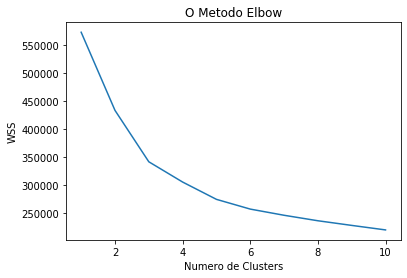

In [78]:
X_elbow = X
wcss = []
 
for i in range(1, 11):
    kmeans_elbow = KMeans(n_clusters = i)
    kmeans_elbow.fit(X_elbow)
    print (i, kmeans_elbow.inertia_)
    wcss.append(kmeans_elbow.inertia_)  
plt.plot(range(1, 11), wcss)
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS') #within cluster sum of squares
plt.show()

Agora então, avaliarei o desempenho do modelo para uma faixa de 3 a 10 clusters.

In [79]:
# Validação da divisão dos clusters
mercado_valida = mercado_6.copy()
for i in range(3, 11):
    modelo = KMeans(n_clusters = i)
    modelo.fit(X)
    mercado_valida['kmeans'] = modelo.labels_
    print('K = {}'.format(i))
    for j in range(1,4):
        acerto = mercado_valida.query('portfolio == @j')['kmeans'].value_counts().max()/mercado_valida.query('portfolio == @j').shape[0]
        cluster = mercado_valida.query('portfolio == @j')['kmeans'].value_counts().index[0]
        print('Portfolio{}'.format(j), 'Cluster {}'.format(cluster), '- Percentual de acerto {:.0%}'.format(acerto))
    print('\n')

K = 3
Portfolio1 Cluster 0 - Percentual de acerto 44%
Portfolio2 Cluster 1 - Percentual de acerto 95%
Portfolio3 Cluster 1 - Percentual de acerto 95%


K = 4
Portfolio1 Cluster 1 - Percentual de acerto 44%
Portfolio2 Cluster 3 - Percentual de acerto 62%
Portfolio3 Cluster 3 - Percentual de acerto 57%


K = 5
Portfolio1 Cluster 4 - Percentual de acerto 43%
Portfolio2 Cluster 3 - Percentual de acerto 62%
Portfolio3 Cluster 3 - Percentual de acerto 57%


K = 6
Portfolio1 Cluster 5 - Percentual de acerto 43%
Portfolio2 Cluster 3 - Percentual de acerto 62%
Portfolio3 Cluster 3 - Percentual de acerto 57%


K = 7
Portfolio1 Cluster 1 - Percentual de acerto 43%
Portfolio2 Cluster 5 - Percentual de acerto 79%
Portfolio3 Cluster 5 - Percentual de acerto 76%


K = 8
Portfolio1 Cluster 1 - Percentual de acerto 43%
Portfolio2 Cluster 6 - Percentual de acerto 73%
Portfolio3 Cluster 6 - Percentual de acerto 69%


K = 9
Portfolio1 Cluster 5 - Percentual de acerto 43%
Portfolio2 Cluster 7 - Percentual 

Escolho por **k = 7** em que os acertos estão mais satisfatórios.

In [96]:
k=7

#### Treinamento do modelo

In [110]:
# Criação do modelo:
modelo = KMeans(n_clusters = k)

In [111]:
# Treinamento do modelo:
modelo.fit(X)

KMeans(n_clusters=7)

In [112]:
# Previsões:
y_pred = modelo.predict(X)

In [113]:
# Centroides:
centr = modelo.cluster_centers_

In [114]:
# Adicionando as classes no df
labels = modelo.labels_
mercado_6['kmeans'] = labels

In [115]:
# Verificando como ficou a divisão dos clusters
print('Divisão das classe pelo K-means')
mercado_6['kmeans'].value_counts()

Divisão das classe pelo K-means


1    108353
3     72367
2     65103
6     56322
4     56096
5     51596
0     37718
Name: kmeans, dtype: int64

##### Avaliação da performance 

In [116]:
for j in range(1,4):
        acerto = mercado_6.query('portfolio == @j')['kmeans'].value_counts().max()/mercado_valida.query('portfolio == @j').shape[0]
        cluster = mercado_6.query('portfolio == @j')['kmeans'].value_counts().index[0]
        print('Portfolio{}'.format(j), 'Cluster {}'.format(cluster), '- Percentual de acerto {:.0%}'.format(acerto))

Portfolio1 Cluster 1 - Percentual de acerto 43%
Portfolio2 Cluster 5 - Percentual de acerto 73%
Portfolio3 Cluster 5 - Percentual de acerto 69%


In [117]:
# Separando os portifolios para Análise:
df_mercado = mercado_6.query('portfolio == 0')
df_p1 = mercado_6.query('portfolio == 1')
df_p2 = mercado_6.query('portfolio == 2')
df_p3 = mercado_6.query('portfolio == 3')

In [118]:
df_mercado['kmeans'].value_counts()

1    108108
3     72214
2     65070
6     56187
4     55947
5     50939
0     37715
Name: kmeans, dtype: int64

In [119]:
df_p1['kmeans'].value_counts()

1    236
6    135
4    108
5     59
0      3
2      2
3      1
Name: kmeans, dtype: int64

Para a empresa do portfolio 1, eu recomendaria os clientes do cluster 1.

In [120]:
df_p2['kmeans'].value_counts()

5    416
3     93
4     30
2     18
1      9
Name: kmeans, dtype: int64

Para a empresa do portfolio 2, eu recomendaria os clientes do cluster 6.

In [121]:
df_p3['kmeans'].value_counts()

5    182
3     59
2     13
4     11
Name: kmeans, dtype: int64

Para a empresa do portfolio 3, eu recomendaria os clientes do cluster 5.

# Conclusão

No modelo proposto, a escolha por k=7 atigiu uma performance de 43% para o portfólio1, 73% para o porfolio 2 e 68% para o porfolio3.

Sugestões para melhorar o modelo:

1. Feature Engineering

2. Testar outros algoritmos